In [1]:
library(R2OpenBUGS)

In [84]:
mymodel <- function() {
    # Likelihood:
    for (i in 1:nFlips) {
        y[i] ~ dbern( theta )
    }
    # Prior distribution:
    theta ~ dbeta( priorA, priorB )
    priorA <- 1
    priorB <- 1
}

In [25]:
# function without return
tmp <- function(a,b) {
    a+b
}
res <- tmp(2,3)
res

[1] 5

In [28]:
# dot in variable names
# https://stats.stackexchange.com/questions/10712/what-is-the-meaning-of-the-dot-in-r

# So we can use parameter type overloading:
a <- list(b=1)
class(a) <- "myclass"
myfunction <- function(x,...) UseMethod("myfunction")
myfunction.myclass <- function(x,...) x$b+1
myfunction.numeric <- function(x,...) x+5
myfunction(a)
myfunction(2)

[1] 2

[1] 7

In [85]:
# Now we should write the model to a file
# we use 
model.file <- file.path(tempdir(), "model.txt")
write.model(mymodel, model.file) # write model text to file

In [2]:
# nFlips = 14
# y = c( 1,1,1,1,1,1,1,1,1,1,1,0,0,0 )
# data = list("nFlips", "y")
data = list(
    nFlips = 14,
    y = c( 1,1,1,1,1,1,1,1,1,1,1,0,0,0 )
)
params <- c("theta")
inits <- NULL

In [6]:
# Sys.getlocale("LC_NUMERIC")
# Sys.setlocale("LC_NUMERIC", "ru_RU.UTF-8")
Sys.setlocale("LC_NUMERIC", "C")
# without this line values in data.txt for OpenBUGS have comma as decimal separator
# so it looks like this:
# list(nFlips=1,40000E+01,...
# and OpenBUGS failed to handle it...
# output was:
#   OpenBUGS version 3.2.3 rev 1012
#   model is syntactically correct
#   expected variable name error pos 14 (error on line 1)
#   variable nFlips is not defined
# 
# the following command may be used for check a separator in an output:
# lapply(data, formatC, digits = 5, format = "E")
#
# This locale "C" use dot as decimal separator

[1] "C"

In [7]:
lapply(data, formatC, digits = 5, format = "E")

$nFlips
[1] "1.40000E+01"

$y
 [1] "1.00000E+00" "1.00000E+00" "1.00000E+00" "1.00000E+00" "1.00000E+00"
 [6] "1.00000E+00" "1.00000E+00" "1.00000E+00" "1.00000E+00" "1.00000E+00"
[11] "1.00000E+00" "0.00000E+00" "0.00000E+00" "0.00000E+00"

In [121]:
# we can use more parameters for bugs function, for example:
# https://cran.r-project.org/web/packages/R2OpenBUGS/vignettes/R2OpenBUGS.pdf
# model <- bugs(data, inits, parameters, model.file = "c:/model.bug",
#  n.chains = 2, n.iter = 8000, n.burnin = 5000, n.thin = 1,
#  codaPkg = TRUE )

out <- bugs(data, inits, params, model.file, n.iter=10000)

In [80]:
samples <- out$sims.matrix[, 'theta']

In [81]:
hist(samples)

ERROR: Error in hist.default(samples): 'x' must be numeric


In [55]:
mean(samples)

[1] 0,7514461

In [57]:
HDIofMCMC = function( sampleVec , credMass=0.95 ) {
    # Computes highest density interval from a sample of representative values,23.3. FUNCTIONS FOR APPROXIMATING HIGHEST DENSITY INTERVALS
    # estimated as shortest credible interval.
    # Arguments:
    # sampleVec
    #   is a vector of representative values from a probability distribution.
    # credMass
    #   is a scalar between 0 and 1, indicating the mass within the credible
    #   interval that is to be estimated.
    # Value:
    #   HDIlim is a vector containing the limits of the HDI
    sortedPts = sort( sampleVec )
    ciIdxInc = floor( credMass * length( sortedPts ) )
    nCIs = length( sortedPts ) - ciIdxInc
    ciWidth = rep( 0 , nCIs )
    for ( i in 1:nCIs ) {
        ciWidth[ i ] = sortedPts[ i + ciIdxInc ] - sortedPts[ i ]
    }
    HDImin = sortedPts[ which.min( ciWidth ) ]
    HDImax = sortedPts[ which.min( ciWidth ) + ciIdxInc ]
    HDIlim = c( HDImin , HDImax )
    return( HDIlim )
}

In [58]:
HDIofMCMC(samples)

[1] 0,5459 0,9375

In [39]:
print(out)

Inference for Bugs model at "/tmp/RtmpbzkbhA/model.txt", 
Current: 3 chains, each with 10000 iterations (first 5000 discarded)
Cumulative: n.sims = 15000 iterations saved
         mean  sd 2.5%  25%  50%  75% 97.5% Rhat n.eff
theta     0.8 0.1  0.5  0.7  0.8  0.8   0.9    1 14000
deviance 15.5 1.3 14.6 14.6 15.0 15.7  19.3    1 15000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = Dbar-Dhat)
pD = 0.8 and DIC = 16.3
DIC is an estimate of expected predictive error (lower deviance is better).


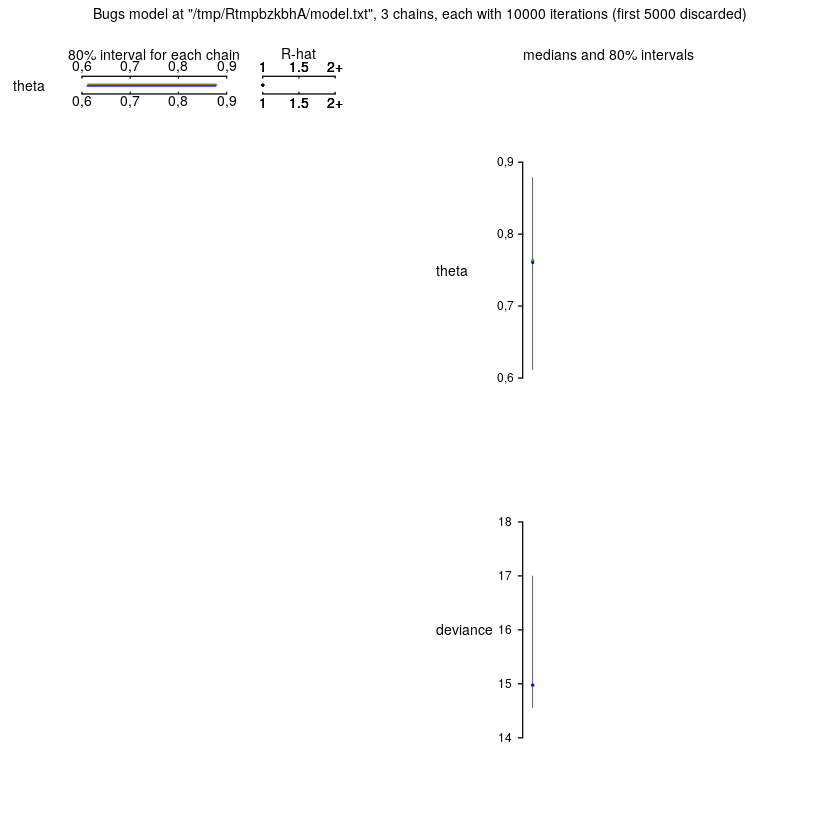

In [40]:
plot(out)

## Coda usage

In [123]:
out2 <- bugs(data, inits, params, model.file, n.iter=10000, codaPkg = TRUE)

In [125]:
library("coda")

Abstracting deviance ... 5000 valid values
Abstracting theta ... 5000 valid values
Abstracting deviance ... 5000 valid values
Abstracting theta ... 5000 valid values
Abstracting deviance ... 5000 valid values
Abstracting theta ... 5000 valid values


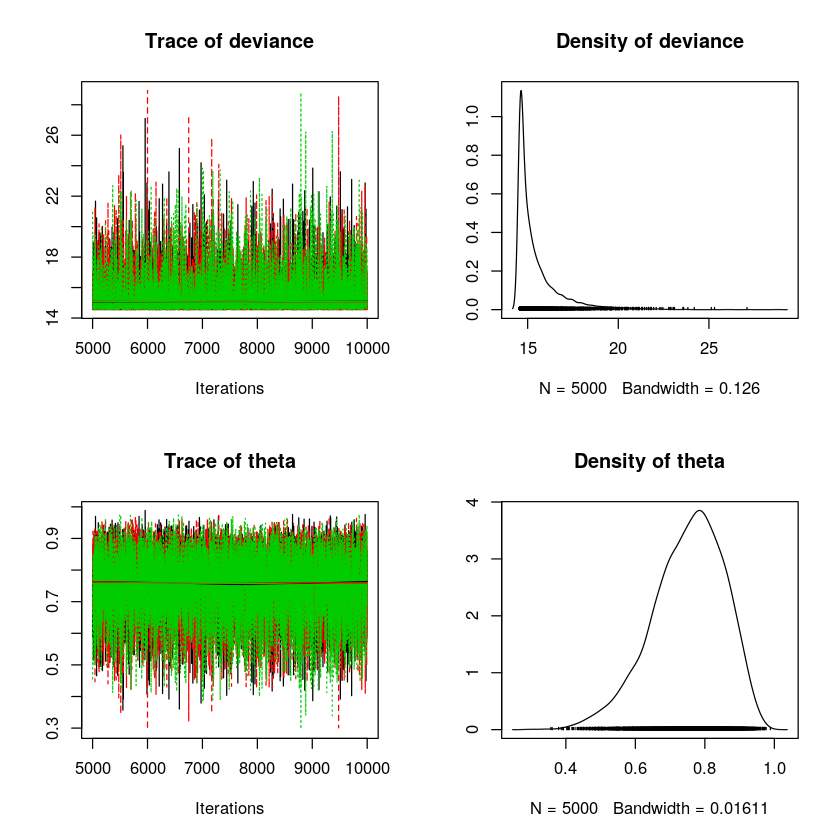

In [126]:
codaobject <- read.bugs(out2)
plot(codaobject)